Code based on: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
import os
import matplotlib.pyplot as plt
%matplotlib inline

# DATA (Cifar-10)
We obtain the Cifar-10 dataset directly through Keras, given as fully labelled training and test sets.

In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Each example is an image of 32x32 pixels, given as triples (RGB) of integer values from 0 to 255. Each example has a label, an integer 0 to 9. The training set contains 50,000 examples, the test set 10,000.

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


Note that each label is in fact an array of length one, as opposed to a simple integer (as it was for MNIST). To solve this, we flatten the label sets.

In [5]:
y_train = y_train.flatten()
y_test = y_test.flatten()
print(y_train.shape)
print(y_test.shape)

(50000,)
(10000,)


Each label represents a different class:

0: airplane										
1: automobile										
2: bird										
3: cat										
4: deer										
5: dog										
6: frog										
7: horse										
8: ship										
9: truck

In [6]:
class_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

We can use matplotlib to quickly visualise some of the data.

Class label: frog


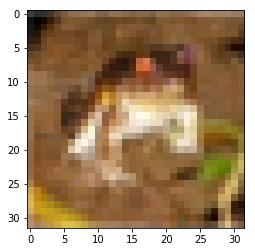

In [7]:
example_id = 0  # pick any integer from 0 to 49999 to visualize a training example
example = x_train[example_id]
label = y_train[example_id]
print("Class label:", class_labels[label])
plt.imshow(example)
plt.show()

Cifar-10 images have 32\*32 pixels, with 3 channels each (RGB), and belong to one of 10 possible classes.

In [8]:
img_rows, img_cols, chns = 32, 32, 3
n_classes = 10

* We are going to build a convolutional neural network that starts with convolutional layers. The shape expected by such layers depends on the settings of the backend used with Keras.
* The channel values are given by integer values from 0 to 255, we normalise this to obtain float values from 0 to 1.
* Labels are given as values 0 to 9, but here we need so-called "one-hot" encodings, e.g. 3 becomes [0,0,0,1,0,0,0,0,0,0]

In [9]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], chns, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], chns, img_rows, img_cols)
    input_shape = (chns, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
    input_shape = (img_rows, img_cols, chns)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print("example one-hot encoding:", y_train[0])

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)
example one-hot encoding: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


# Model architecture & settings

We build a CNN with two Convolutional layers, followed by MaxPooling, followed by some Dense layers (with Dropout).
* Initialise a Keras Sequential Model
* Add a Convolutional layer (with a 3x3 kernel and ReLU activations), followed by Batch Normalization and Dropout. The first layer must explicitly receive the shape of the input, following layers can do automatice shape inference.
* Add another Convolutional layer, followed by a single MaxPooling layer (with a 2x2 patch) for down-scaling, and then again Batch Normalization and Dropout. 
* We now wish to add Dense layers, but those expect samples to be given as (flat) vectors. To transform the data into this shape we use the Flatten layer. We then add a Dense layer, Batch Normalization, Dropout, and a final Dense layer with softmax activation to obtain class probabilities/predictions.
* Optional: print a summary of the model
* Compile the model with the following settings:
    * use the "adam" optimizer to train the model
    * MNIST is a multi-class classification problem, use categorical cross entropy loss function
    * output accuracy (% of correctly classified instances) when evaluating the model

In [11]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
__________

# Training the model
Train the model (using stochastic gradient descent) with given batch size, for given number of epochs. We split of 1/10-th of the data (5,000 of the 50,000 samples) as validation data, such that we can use the validation accuracy for hyperparameter tuning.

In [12]:
batch_size = 100
epochs = 20

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 29s 654us/step - loss: 1.7414 - acc: 0.4130 - val_loss: 1.3573 - val_acc: 0.5184
Epoch 2/20
45000/45000 [==============================] - 27s 605us/step - loss: 1.2878 - acc: 0.5395 - val_loss: 1.5848 - val_acc: 0.4632
Epoch 3/20
45000/45000 [==============================] - 27s 606us/step - loss: 1.1301 - acc: 0.5989 - val_loss: 1.1192 - val_acc: 0.6162
Epoch 4/20
45000/45000 [==============================] - 27s 609us/step - loss: 1.0407 - acc: 0.6346 - val_loss: 1.1075 - val_acc: 0.6122
Epoch 5/20
45000/45000 [==============================] - 27s 609us/step - loss: 0.9841 - acc: 0.6521 - val_loss: 0.9766 - val_acc: 0.6502
Epoch 6/20
45000/45000 [==============================] - 27s 607us/step - loss: 0.9391 - acc: 0.6710 - val_loss: 0.9253 - val_acc: 0.6756
Epoch 7/20
45000/45000 [==============================] - 27s 610us/step - loss: 0.9047 - acc: 0.6812 - val_loss: 0.8

# Evaluating the model

We evaluate the model using the test set, obtaining the test loss and accuracy (% examples correctly classified)

In [13]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.8299461775779724
Test accuracy: 0.7161


# Saving the model
We save the model to a .h5 file, such that we can load it later in other notebooks.

In [14]:
model.save(os.path.join("models", "cnn_cifar10.h5"))